<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project1_numerical_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Heat transport

In this project we will discretize and timestep two systems that describe heat transport. In the first part we will timestep a box model for the Earth's surface temperature with heat buffering provided by the deep ocean. In the second part, we will timestep the one-dimensional diffusion equation which can be used to describe heat moving through a medium (e.g. the ground or still air and water).

Through this project, we will learn how to efficiently timestep ordinary and partial differential equations and examine errors introduced by the numerical discretization. We will also have the chance to explore the timescales and physical processes involved in heat transport in the climate system.

## 1. Climate box model

In this part of the project we will timestep the following box model.

$$ C_s \partial_t T = F(t) - \gamma(T-\theta) $$

$$ C_d \partial_t \theta = \gamma (T-\theta) $$

Here, $T(t)$ represents the global mean surface temperature as a function of time and $\theta(t)$ is the temperature of the deep ocean, both expressed as the difference between the temperature and a pre-industrial equilibrium in units of $^\circ K$. The net surface heat flux, $F(t)$, drives departures from the pre-industrial temperatures. The heat flux between the surface and deep ocean is assumed to be proportional to the difference between the surface and deep ocean temperatures. The constants are the heat capacity of the surface of the Earth, $C_s$, the heat capacity of the deep ocean, $C_d$, and the heat flux coefficient, $\gamma$, all given in units of $W/^\circ K/m^2$.

This model is inspired by a more complicated version of a two box climate model in the paper referenced below. (Interested students might consider adding some additional features from their model, but this is not required for this project).

*Nicklas, J.M., Fox-Kemper, B. and Lawrence, C., 2025. Efficient Estimation of Climate State and Its Uncertainty Using Kalman Filtering with Application to Policy Thresholds and Volcanism. Journal of Climate, 38(5), pp.1235-1270.*

Below, we start to build code to solve these equations. Execute the code cells below.  In some cases you will be asked to add code.

Student tasks are in [Section 1.1](#section1pt1), [Section 1.2](#section1pt2), and [Section 1.3](#section1pt3).

In [42]:
# Before we start, import necessary libraries. Run this cell first.
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time

Now, let's define values for the various constants. These values are taken from Nicklas et al., 2025.

In [43]:
C_s = 17 # heat capacity of the Earth's surface (W/m^2/K)
C_d = 156 # heat capacity of the deep ocean (W/m^2/K)
gamma = 0.67 # heat exchange coefficient between surface and deep ocean (W/m^2/K)

Now, let's define a function for F(t), the net surface heat flux (in units of $W/m^2$) that will force our model. This function is here to represent the heat imbalance caused by antropogenic greenhouse gases in the atmosphere. When $F=0$, there is no net surface heat flux. The argument, $t$, is the time in years. We will let $t=0$ denote the start of our additional warming, and we set $F=1$ if $t<200$ years and $F=0$ if $t>200$ years. This corresponds to a very bad-case emissions scenario with an abrupt drop in emissions after 200 years.

In [44]:
def F(t):
    return 1 if t < 200 else 0

Next, set the initial conditions. We will use arrays `T` and `theta`. `T[i]` represents the ith value in the array. We will use `T[0]` and `theta[0]` to hold the initial conditions. Subsequent values, `T[2]`, `T[3]`, etc. will be determined by timestepping the equations. We start by initializing the arrays using numpy and filling them with zeros and then set the initial values (this isn't necessary here since our values are zero anyway, but the code is here to that you can change the initial conditions easily)

In [45]:
Nt = 500 # number of time steps (including the starting point)
T = np.zeros(Nt) # surface temperature array
theta = np.zeros(Nt) # deep ocean temperature array
T[0] = 0 # initial surface temperature anomaly (ºK)
theta[0] = 0 # initial deep ocean temperature anomaly (ºK)

Now, create an array with the time (in years) corresponding to each time index. Also, calculate the timestep, `dt`.

In [46]:
t = np.linspace(0, 500, Nt) # time in years.  This starts at 0 and ends at 500, with Nt total points
dt = t[1] - t[0] # timestep in years

Finally, we are ready to create a for loop to timestep the equations listed at the top of the section.

### 1.1 Student task:
<a id='section1pt1'></a>
Fill in the interior of the for loop to timestep the equations from the start of Section 1 using the Explicit Euler method.

In [47]:
for i in range(0, Nt-1):
    T[i+1] = T[i] + dt * (F(t[i]) - gamma * (T[i] - theta[i])) / C_s
    theta[i+1] = theta[i] + gamma * (dt / C_d) * (T[i] - theta[i])

After you are finished, run the cell below to plot the results

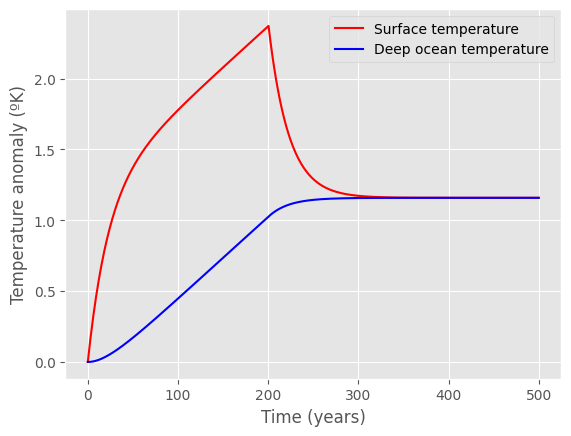

In [48]:
plt.style.use('ggplot')
plt.plot(t,T,'r-')
plt.plot(t,theta,'b-')
plt.legend(['Surface temperature','Deep ocean temperature'])
plt.xlabel('Time (years)')
plt.ylabel('Temperature anomaly (ºK)')
plt.show()

### 1.2 Student task
<a id='section1pt2'></a>
**Discuss the rates of change the temperature of the Earth's surface and the deep ocean at the start of the model run.  Can you explain these rates by defining characteristic timescales from the box model equations?**

INSERT DISCUSSION HERE (~1 paragraph)

At the start of the run, when T and theta are still zero, we essentially have:

$
\frac{dT}{dt} = \frac{1}{C_s}
$

$
\frac{d\theta}{dt} = 0
$
, so the surface will warm immediately, whereas the deep ocean warms much slower. This is indeed seen on the figure above.

We can easily find the characteristic timescales, which are approximately
C_s/gamma = 25 years for surface and C_d/gamma = 232 years for deep ocean. This confirms that the surface warms/cools much faster than the deep ocean.

After a while, T gets larger, so dT/dt will slowly decrease, whereas dtheta/dt will slowly increase, until they reach a similar almost linear slope.

When then the forcing is taken away after 200 years, dT/dt suddenly becomes negative, so T will decreases very fast. On the other hand, dtheta/dt will keep increasing, but slower then before (as T - theta keeps getting closer to zero).  After approx t = 320 years, the surface and deep ocean reach the same value enter a steady state.

### 1.3 Student task
<a id='section1pt3'></a>
Modify the forcing function, `F(t)` above with 2-3 scenarios of your choice. Plot the temperature response for each scenario and briefly (2-3 sentences each) describe the temperature responses in each scenario. You will need to replicate some of the code blocks above so that you can produce a new set of plots below.

In [49]:
def plot_scenario(F):
  Nt = 500 # number of time steps (including the starting point)
  T = np.zeros(Nt) # surface temperature array
  theta = np.zeros(Nt) # deep ocean temperature array
  T[0] = 0 # initial surface temperature anomaly (ºK)
  theta[0] = 0 # initial deep ocean temperature anomaly (ºK)

  t = np.linspace(0, 500, Nt) # time in years.  This starts at 0 and ends at 500, with Nt total points
  dt = t[1] - t[0] # timestep in years

  for i in range(0, Nt-1):
      T[i+1] = T[i] + dt * (F(i) - gamma * (T[i] - theta[i])) / C_s
      theta[i+1] = theta[i] + gamma * (dt / C_d) * (T[i] - theta[i])

  plt.plot(t,T,'r-')
  plt.plot(t,theta,'b-')
  plt.legend(['Surface temperature','Deep ocean temperature'])
  plt.xlabel('Time (years)')
  plt.ylabel('Temperature anomaly (ºK)')
  plt.show()

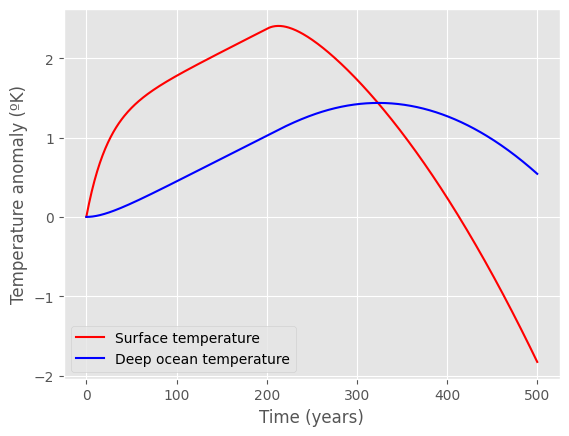

In [50]:
def F1(t):
    if t < 200: # constant positive forcing for 200 years
        return 1
    else:
        return 1 - 0.01*(t-200) # linear decrease in forcing, which becomes negative t=300

plot_scenario(F1)

***Scenario 1: linearly decreasing forcing after 200 years***

As before, both the surface and deep ocean temperatures increase for the first 200 years. After t = 200 years, although the forcing starts decreasing linearly, the surface temperature still increases a bit further (sort of overshoot). Most interesingly, after 300 years (when forcing becomes zero and subsequently negative), the deep ocean temperature initially continues to increase a bit (crossing the surface temperature), and then slowly starts decreasing.

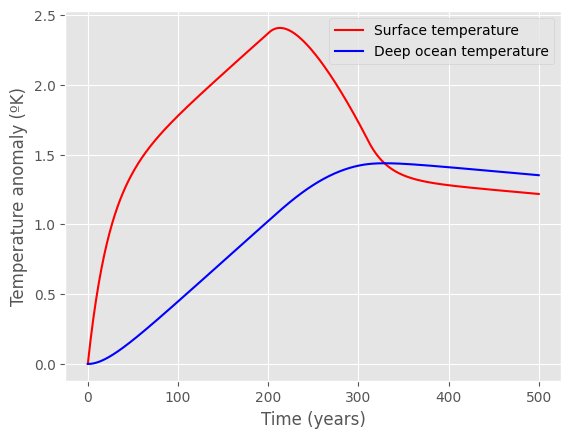

In [51]:
def F2(t):
    if t < 200:
        return 1                # constant positive forcing for 200 years
    elif 200 <= t < 310:
        return 1 - 0.01*(t-200) # linear decrease, crosses zero at t=300
    else:
      return -0.1 # constant negative forcing after t=310

plot_scenario(F2)

***Scenario 2: linearly decreasing forcing after 200 years, with constant negative forcing after 310 years***

This scenario is similar to the one before, but here the forcing is kept at -0.1 after t = 310 years. Interestingly, the deep ocean temperature stays warmer than the surface temperature after t = 310 years. So this indicates that once the deep ocean has warmed enough to exceed the surface temperature, it is very difficult to cool it back down below the surface level.

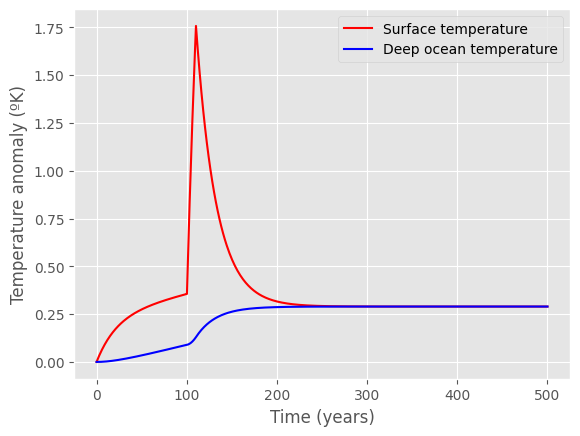

In [52]:
def F3(t):
    if t < 100:
        return 0.2  # mild forcing
    elif t < 110:
        return 3.0  # sudden strong forcing pulse
    else:
        return 0  # followed by zero forcing


plot_scenario(F3)

***Scenario 3: sudden increase in forcing for 10 years followed by zero forcing***

In the first 100 years, temperatures again rise as expected (fast for surface, slower for deep ocean). During the short period of extreme forcing, the surface warms really fast, whereas the deep ocean responds only slightly. Interestingly, after the forcing ends, the surface temperature drops below the value it had at t = 100 years (before the forcing pulse). If this would happen in the real world, it would be somewhat misleading for many people, as the surface temperature seems to recover, but the deep ocean actually stores most of the heat.


## 2. Diffusion equation

In this part of the project we will solve the 1-D diffusion equation:

$$ \partial_t c = \kappa \partial_x^2 c $$

We will use second order finite differences to approximate the $x$-derivatives, and we will implement and compare two timestepping methods.

Student tasks are in [Section 2.1](#section2pt1), [Section 2.2](#section2pt2), and [Section 2.3](#section2pt3).

First, let's discretize the second order derivative using finite differences. The function below builds a coefficient matrix, $M$, so that $Mc$ is a discretized version of $\partial^2_x c$, where in our discretized version $c$ is a column vector.

In [53]:
def construct_M(x):
    # Build a coefficient matrix, such that M*c is the discrete version of d^2/dx^2(c)
    dx = x[1] - x[0]  # Infer the uniform grid spacing
    Nx = len(x)
    M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2
    M = sp.csr_matrix(M) # Turn M into a sparse matrix to save memory and improve speed
    return M

Now, define two functions to timestep the diffusion equation. The code below timesteps the diffusion equation using the expicit Euler method. The function takes in a vector of discrete positions, `x`, discrete times, `t`, and the diffusivity, `kappa`. The vectors `x` and `t` dictate the discretization of the problem in space and time, and the grid spacing must be constant in space and time. The boundary conditions are $\partial_x c=0$ at the starting and ending points in `x`.

In [54]:
def EE(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler using second order finite difference methods

    start_time = time.time()  # Start a timer

    # Infer the timestep from the time array
    dt = t[1] - t[0]

    M = construct_M(x)  # Construct the coefficient matrix for the second derivative

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt):  # loop over the number of timesteps
      c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]
      # Enforce the boundary conditions (no flux)
      c[0, k] = c[1, k]
      c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    print(f"Explicit Euler method took {end_time - start_time:.2f} seconds")

    return c

Similarly, the function below timesteps the diffusion equation with the Crank-Nicolson method

In [55]:
def CN(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# crack nicolson using second order finite difference methods
    start_time = time.time()  # Start a timer

    # Infer the timestep from the time array
    dt = t[1] - t[0]

    M = construct_M(x)  # Construct the coefficient matrix for the second derivative

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    A = sp.eye(Nx) - 0.5 * dt * kappa * M  # This matrix appears on the LHS in the C-N scheme
    A_inv = spla.inv(A) # Calculate the inverse of A (this only needs to be done once)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt): # loop over the number of timesteps
        c[:, k] = A_inv @ (c[:, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1]))
        # Enforce the boundary conditions
        c[0, k] = c[1, k]
        c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    print(f"Crank-Nicolson method took {end_time - start_time:.2f} seconds")

    return c

Next, create a function to set the initial conditions. The exact solution to the unbounded diffusion equation with a delta function initial condition is:

$$\left(\frac{1}{4\pi\kappa t}\right)^{1/2}e^{-x^2/(4\kappa t)}$$

The function below sets the initial condition by evaluating the exact solution at a given time. Note that it is important that we don't evaluate the exact solution at `t_ic=0` since this will return a delta function which will be undefined on our finite grid. The value of `t_ic` is set within the `EE` and `CN` functions.

In [56]:
# Function to set the initial condition from the exact solution at time t_start
def set_ics(x, kappa, t_ic):
    c_ic = (4*np.pi*kappa*t_ic)**(-0.5)*np.exp(-x**2 / (4*kappa*t_ic))
    # Enforce the boundary conditions
    c_ic[0] = c_ic[1]
    c_ic[-1] = c_ic[-2]
    return c_ic


Finally, define some parameters and the x and t vectors:

In [57]:
# Defining parameters
kappa = 0.01  # diffusivity, original 0.001

# Timestepping parameters
t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
Nt = 1000  # number of timesteps

# Size of the physical domain
x_start = -1
x_end = 1
Nx = 100

t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x

Run each method once:

In [58]:
# Run the simulations
c_EE = EE(x, t, kappa) # explicit Euler
c_CN = CN(x, t, kappa) # Crank-Nicolson

Explicit Euler method took 0.06 seconds
Crank-Nicolson method took 0.06 seconds


/usr/local/lib/python3.12/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/usr/local/lib/python3.12/dist-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


and finally, plot the results side-by-side

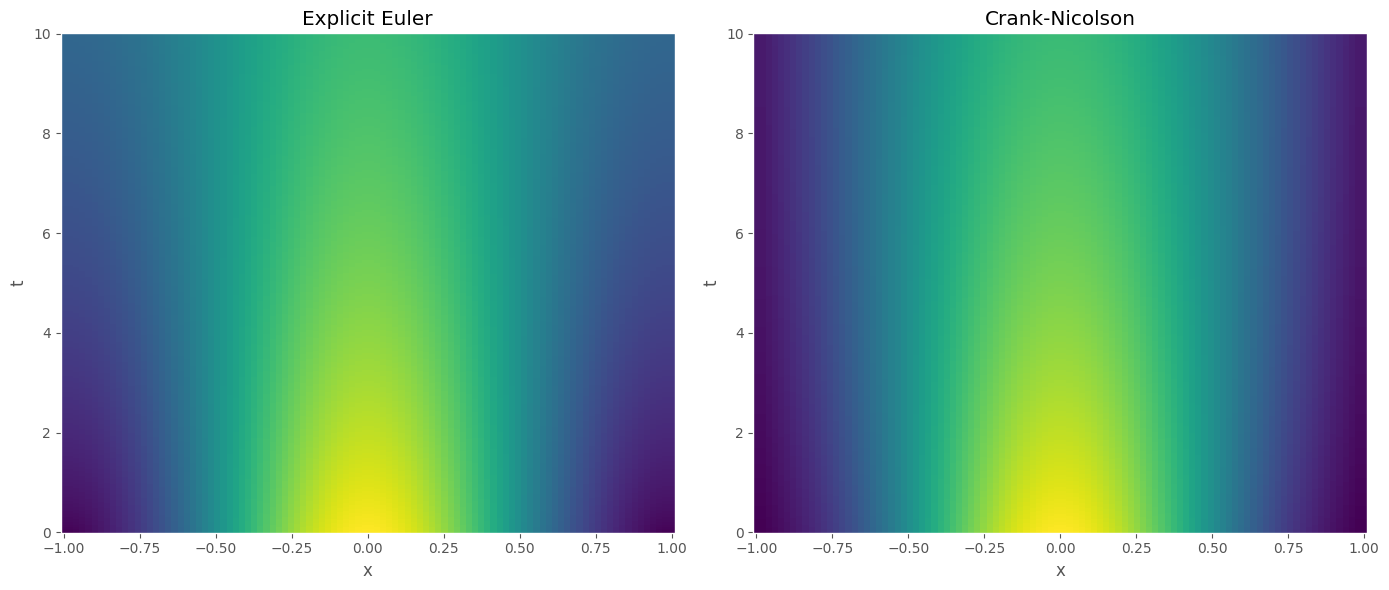

In [59]:
# Plot the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.pcolormesh(x, t, c_EE.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Explicit Euler')

plt.subplot(1, 2, 2)
plt.pcolormesh(x, t, c_CN.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank-Nicolson')

plt.tight_layout()
plt.show()

## 2. Student investigation

### 2.1 Stability
<a id='section2pt1'></a>
**The explicit Euler and Crank-Nicolson methods have different stability properties. To explore this, try increasing the diffusivity, $\kappa$, and see how each method responds. Discuss your findings below (~2-3 sentences).**

When increasing kappa, both the Euler and Crank Nicolson plots show more diffusive solutions. However, the Euler method quickly introduces non-physical (numerical) diffusion, while the Crank–Nicolson method remains stable even for higher kappa values. Specifically, the Euler method already clearly over-smooths from about kappa = 0.01, and becomes unstable once kappa goes above 0.021. By using von Neumann Fourier stability analysis, I found the stability condition (for Euler method):

$\Delta t \le \frac{(\Delta x)^2}{2\,\kappa} $

which shows that for $\Delta x = 0.02$ and $\Delta t = 0.01 $:

$\kappa \le \frac{(\Delta x)^2}{2\,\Delta t}
= 0.02$,

confirming my observations. The Crank Nicolson scheme is stable for all kappa, which could also be checked mathematically (again stability analysis with Fourier modes).

### 2.2 Accuracy
<a id='section2pt2'></a>
**Next, we will examine the accuracy of the numerical methods used above. In order to do this, it is useful to compare our numerical solutions with the exact solution to the diffusion equation. Below, write code to plot the exact solution and the numerical solution using explicit Euler and Crank-Nicolson at the final time ($t=10$). Note that you can use the exact solution to the diffusion equation in an unbounded domain in $x$ and keep in mind that the exact solution and numerical solutions will differ for later times when boundary effects are felt.**

Explicit Euler method took 0.06 seconds
Crank-Nicolson method took 0.06 seconds
Explicit Euler method took 0.06 seconds
Crank-Nicolson method took 0.06 seconds


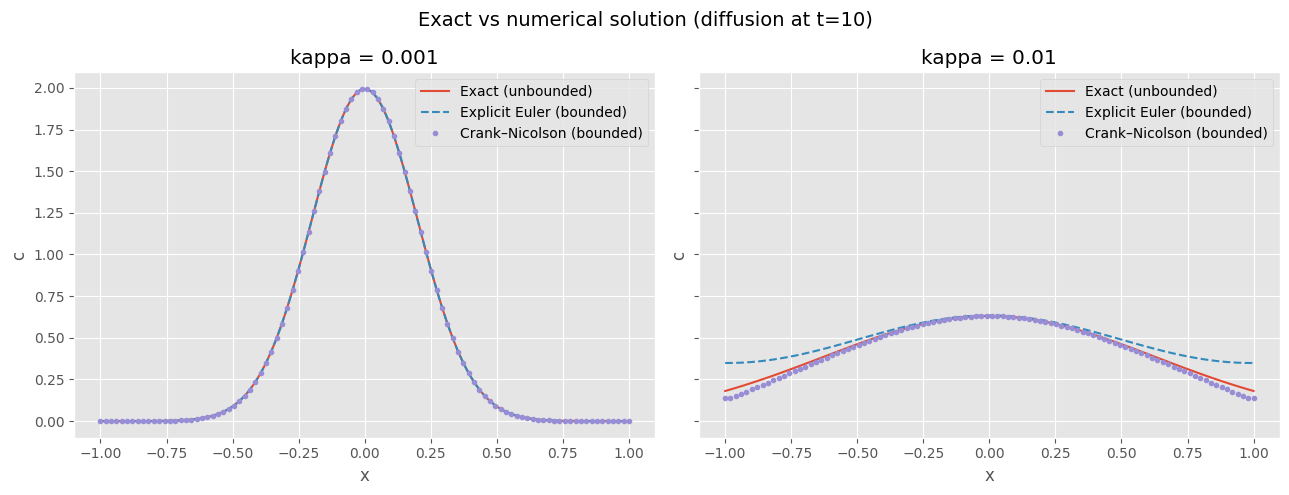

In [60]:
# Add code to plot exact and numerical solutions
kappas = [0.001, 0.01]
t_ic = 10

def exact_solution(x, t, kappa): # define exact solution function
  return (4 * np.pi * kappa * t)**(-0.5) * np.exp(-x**2 / (4 * kappa * t))

fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

for kappa, ax in zip(kappas, axes):
    c_EE = EE(x, t, kappa)
    c_CN = CN(x, t, kappa)
    c_exact = exact_solution(x, t_end + t_ic, kappa) # shift time window, as t_ic was 10 for numerical models

    ax.plot(x, c_exact, label="Exact (unbounded)")
    ax.plot(x, c_EE[:, -1], '--', label='Explicit Euler (bounded)')
    ax.plot(x, c_CN[:, -1], '.', label='Crank–Nicolson (bounded)')
    ax.set_xlabel('x')
    ax.set_ylabel('c')
    ax.set_title(f'kappa = {kappa}')
    ax.legend()

fig.suptitle('Exact vs numerical solution (diffusion at t=10)', fontsize=14)
plt.tight_layout()
plt.show()

The numerical solutions are plotted at t = 10, but had as initial condition the exact solution evaluated at t_ic = 10. Therefore, the corresponding exact solution was taken at t = 20 for comparison.

 For low kappa, it is clear that the three curves closely align. However, for larger kappa values, errors become more noticeable near the boundaries (especially for explicit Euler as it is a first order scheme), so  clearly boundary effects come into play. It is also visible how the numerical solutions cleary satisfy the zero gradient condition at the boundaries, which does not hold for the exact solution.

**The difference between the exact solution and the numerical approximation can be quantified by various measures of error. The *local error* is the difference between the exact solution and the numerical approximation after one timestep. The *global error* is the difference between the solutions after a fixed amount of time (which includes the accumulation of multiple steps of local error). A method is first order accurate if the global error is linearly proportional to the timestep. A method is second order accurate if the global error varies quadratically with the timestep. Below, calculate and plot the global error for the Explicit Euler and Crank-Nicolson methods and use your results to infer the order of accuracy of each scheme.**

Explicit Euler method took 0.01 seconds
Explicit Euler method took 0.01 seconds
Explicit Euler method took 0.01 seconds
Explicit Euler method took 0.01 seconds
Explicit Euler method took 0.01 seconds
Explicit Euler method took 0.00 seconds
Explicit Euler method took 0.00 seconds


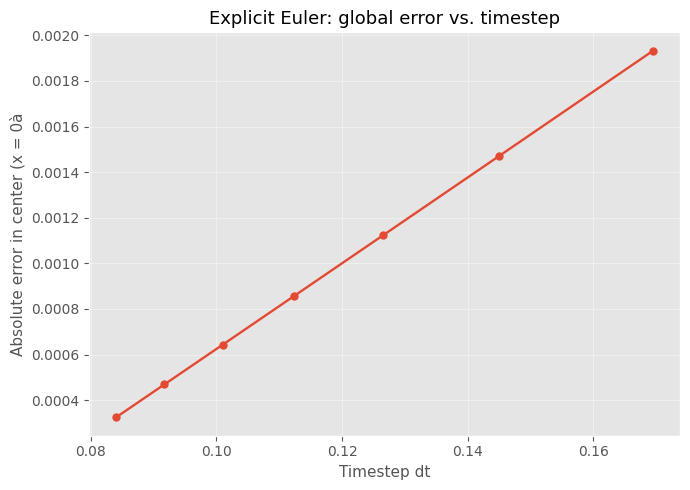

In [61]:
kappa = 0.001
Nt = [120, 110, 100, 90, 80, 70, 60, 50, 40]  # different timesteps dt
x_start, x_end = -1, 1
Nx = 101
x = np.linspace(x_start, x_end, Nx)
dx = x[1] - x[0]
x_error = 50  # centered point at x = 0
t_ic = 10
t_start, t_end = 0, 10

dt_list = []
err_EE = []

for N in Nt:
    t = np.linspace(t_start, t_end, N)
    dt = t[1] - t[0]
    dt_list.append(dt)

    # Explicit Euler stability condition
    dt_max = dx**2 / (2 * kappa)
    c_exact = exact_solution(x, t_ic + t[-1], kappa)

    if dt <= dt_max:
        c_EE = EE(x, t, kappa)
        err = abs(c_EE[x_error, -1] - c_exact[x_error])
        err_EE.append(err)
    else:
        err_EE.append(np.nan)

plt.figure(figsize=(7, 5))
plt.plot(dt_list, err_EE, 'o-', linewidth=1.7, markersize=5)
plt.title('Explicit Euler: global error vs. timestep', fontsize=13)
plt.xlabel('Timestep dt', fontsize=11)
plt.ylabel('Absolute error in center (x = 0à', fontsize=11)
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()


The global error was calculated only at centered x = 0 as the absolute value of the difference between the explicit Euler and the exact solution. This clearly follows a linear behavior, indicating that explicit Euler is indeed 1e order accurate.

 However, I do want to mention that I also looked at other (higher) Nt values and other kappa values, and that the results weren't always consistent. In some cases, the error even decreased for larger dt values, likely due to numerical artifacts. I also examined other output times (not only t = 10) and different spatial locations (e.g. near the boundaries), where the results were generally less consistent due to boundary influences.

Crank-Nicolson method took 1.66 seconds
Crank-Nicolson method took 1.52 seconds
Crank-Nicolson method took 1.95 seconds
Crank-Nicolson method took 1.85 seconds
Crank-Nicolson method took 1.30 seconds
Crank-Nicolson method took 1.19 seconds
Crank-Nicolson method took 1.11 seconds
Crank-Nicolson method took 1.07 seconds


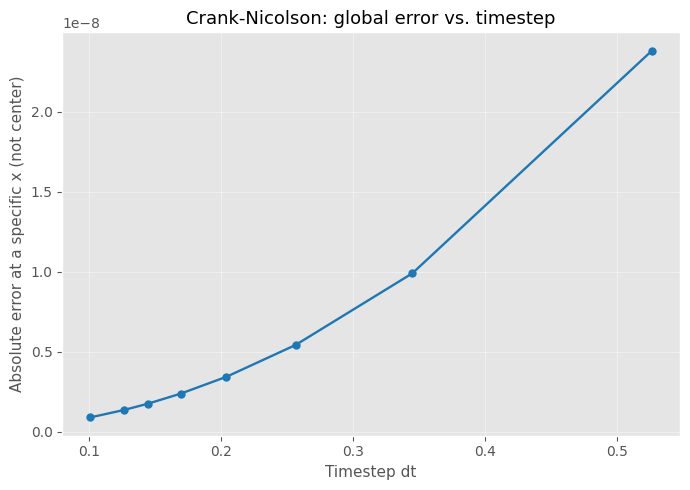

In [62]:
kappa = 0.001
Nt = [100, 80, 70, 60, 50, 40, 30, 20]   # different timesteps
x_start, x_end = -1, 1
Nx = 2001
x = np.linspace(x_start, x_end, Nx)
dx = x[1] - x[0]
i0 = 180 # evaluate at a specific x (here not in center)
t_ic = 10
t_start, t_end = 0, 10

dt_list = []
err_CN = []

for N in Nt:
    t = np.linspace(t_start, t_end, N)
    dt = t[1] - t[0]
    dt_list.append(dt)
    i_t = int(N / 10)  # evaluate error near t = 1

    c_exact = exact_solution(x, t_ic + t[i_t], kappa)
    c_CN = CN(x, t, kappa)
    err = abs(c_CN[i0, i_t] - c_exact[i0])
    err_CN.append(err)

plt.figure(figsize=(7, 5))
plt.plot(dt_list, err_CN, 'o-', color='tab:blue', linewidth=1.7, markersize=5)
plt.title('Crank-Nicolson: global error vs. timestep', fontsize=13)
plt.xlabel('Timestep dt', fontsize=11)
plt.ylabel('Absolute error at a specific x (not center)', fontsize=11)
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()


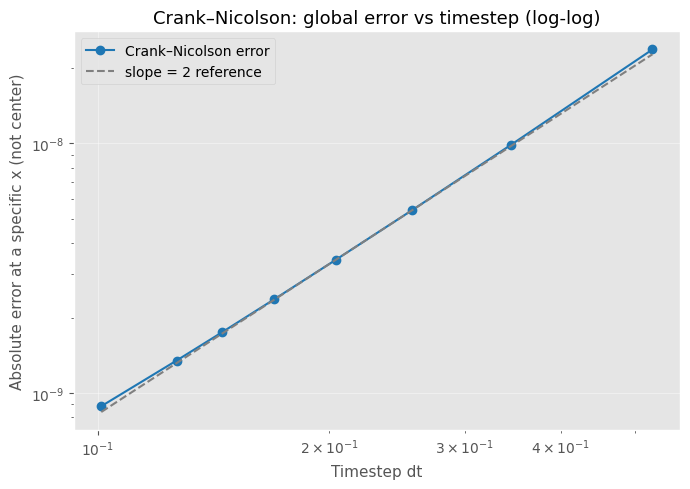

In [63]:

plt.figure(figsize=(7, 5))
plt.loglog(dt_list, err_CN, 'o-', color='tab:blue', label='Crank–Nicolson error')

middle_dt = dt_list[4]
middle_err = err_CN[4]

slope = middle_err * (np.array(dt_list) / middle_dt)**2
plt.loglog(dt_list, slope, '--', color='gray', label='slope = 2 reference')

plt.title('Crank–Nicolson: global error vs timestep (log-log)', fontsize=13)
plt.xlabel('Timestep dt', fontsize=11)
plt.ylabel('Absolute error at a specific x (not center)', fontsize=11)
plt.grid(True, alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


For the Crank–Nicolson scheme, I could use really large values of Nx, as the method remains stable for all timestep sizes. To minimize spatial discretization error, I thus chose Nx >> Nt.

From the plots above, it is clear that the global error varies quadratically with the timestep, and the log–log plot also shows an almost perfect straight line with slope = 2. This indeed confirms the expected second order accuracy for the Crank–Nicolson method.

However, compared to the explicit Euler analysis, I made a few small adjustments. Instead of evaluating the error at the center (x = 0) and at t = 10, I found more consistent results when looking at a point away from the center (closer to the boundary in this case) and at an earlier time (t = 1). This might be because, at earlier times, the solution is less affected by spatial errors. At later times, it was visible that the spatial error started to play a role, especially for smaller timesteps.

**Finally, select a given error tolerance and explore whether explicit Euler or Crank-Nicoslon is more efficient (faster) at generating solutions with error less than your error tolerance. Discuss your conclusion and add supporting figures if necessary.**

Here, I will investigate the total global error across the full spatial domain by taking the average error over all grid points, but still with a low diffusivity so that boundary effects remain limited. This approach provides a more balanced comparison between the numerical methods, rather than focusing on a single spatial location. I studied multiple cases, of which I showed two below:

**Case 1:**

kappa = 0.001

Error tolerance = 1*5e-5


**Case 2:**

kappa = 0.001

Error tolerance = 1*722e-5

In [64]:
import time

kappa = 0.001
eps_tol = 1.5e-5  # case 1
# eps_tol = 1.722e-06 # case 2
Nx_list = [101, 201, 401, 801, 1001, 1401]
Nt_list = [10, 20, 40, 80, 100, 200, 500, 800, 1000, 1500, 2000]
EE_best = (0, 0, 0, 0, 0, 10)  # (Nx, Nt, dx, dt, err, runtime)
CN_best = (0, 0, 0, 0, 0, 10) # 10 is chosen to be the start best runtime

for Nx in Nx_list:
    x = np.linspace(-1, 1, Nx)
    dx = x[1] - x[0]
    print(f"\n Nx = {Nx} and dx = {dx:.3e} ")

    for Nt in Nt_list:
        t = np.linspace(t_start, t_end, Nt)
        dt = t[1] - t[0]
        c_exact = exact_solution(x, t_ic + t[-1], kappa)

        #Crank–Nicolson
        t0 = time.time() # I decided to time again, to make it easier to get an overview
        c_CN = CN(x, t, kappa)
        runtime_CN = time.time() - t0
        err_CN = np.mean(np.abs(c_CN[:, -1] - c_exact))
        print(f"CN  : Nt={Nt:4d}, dt={dt:.3e}, err={err_CN:.3e}, time={runtime_CN:.3f} s ", end="")

        if err_CN <= eps_tol:
            print("GOOD, below epsilon")
            if runtime_CN < CN_best[5]: # we save the fastest runtime that is below the error tolerance
                CN_best = (Nx, Nt, dx, dt, err_CN, runtime_CN)
        else:
            print("")

        # Explicit Euler
        dt_max = dx**2 / (2 * kappa)
        if dt <= dt_max:
            t0 = time.time()
            c_EE = EE(x, t, kappa)
            runtime_EE = time.time() - t0
            err_EE = np.mean(np.abs(c_EE[:, -1] - c_exact))
            print(f"EE  : Nt={Nt:4d}, dt={dt:.3e}, err={err_EE:.3e}, time={runtime_EE:.3f} s ", end="")

            if err_EE <= eps_tol:
                print("GOOD, below epsilon")
                if runtime_EE < EE_best[5]: # # we save the fastest runtime that is below the error tolerance
                    EE_best = (Nx, Nt, dx, dt, err_EE, runtime_EE)
            else:
                print("")
        else:
            print(f"EE  | Nt={Nt:4d}, dt={dt:.3e}, UNSTABLE")


print("Fastest Nt and Nx combination")
if EE_best:
    Nx, Nt, dx, dt, err, runtime = EE_best
    print(f"EE: Nx={Nx}, Nt={Nt}, dx={dx:.3e}, dt={dt:.3e}, err={err:.3e}, time={runtime:.3f} s")

if CN_best:
    Nx, Nt, dx, dt, err, runtime = CN_best
    print(f"CN: Nx={Nx}, Nt={Nt}, dx={dx:.3e}, dt={dt:.3e}, err={err:.3e}, time={runtime:.3f} s")



 Nx = 101 and dx = 2.000e-02 
Crank-Nicolson method took 0.03 seconds
CN  : Nt=  10, dt=1.111e+00, err=2.075e-04, time=0.032 s 
EE  | Nt=  10, dt=1.111e+00, UNSTABLE
Crank-Nicolson method took 0.03 seconds
CN  : Nt=  20, dt=5.263e-01, err=2.698e-04, time=0.031 s 
EE  | Nt=  20, dt=5.263e-01, UNSTABLE
Crank-Nicolson method took 0.05 seconds
CN  : Nt=  40, dt=2.564e-01, err=2.850e-04, time=0.046 s 
EE  | Nt=  40, dt=2.564e-01, UNSTABLE
Crank-Nicolson method took 0.03 seconds
CN  : Nt=  80, dt=1.266e-01, err=2.886e-04, time=0.030 s 
Explicit Euler method took 0.01 seconds
EE  : Nt=  80, dt=1.266e-01, err=2.611e-04, time=0.005 s 
Crank-Nicolson method took 0.03 seconds
CN  : Nt= 100, dt=1.010e-01, err=2.891e-04, time=0.031 s 
Explicit Euler method took 0.01 seconds
EE  : Nt= 100, dt=1.010e-01, err=1.496e-04, time=0.005 s 
Crank-Nicolson method took 0.04 seconds
CN  : Nt= 200, dt=5.025e-02, err=2.897e-04, time=0.038 s 
Explicit Euler method took 0.01 seconds
EE  : Nt= 200, dt=5.025e-02, er

**RESULTS:**

*Case 1: error tolerance 1.5e-05*

EE: Nx=401, Nt=1500, dx=5.000e-03, dt=6.671e-03, err=1.123e-05, time=0.091 s

CN: Nx=401, Nt=20, dx=5.000e-03, dt=5.263e-01, err=1.361e-05, time=0.123 s

*Case 2: error tolerance 1.722e-06*

EE: Nx=0, Nt=0, dx=0.000e+00, dt=0.000e+00, err=0.000e+00, time=10.000 s

-> Here no stable configuration went below the error tolerance

CN: Nx=1401, Nt=80, dx=1.429e-03, dt=1.266e-01, err=1.036e-06, time=0.827 s

----------------------------------------

These results show that if the error tolerance is sufficiently high, the explicit Euler method can satisfy the accuracy requirement faster than Crank-Nicolson, given its simplicity as a first-order scheme. However, it does require a much higher Nt compared to Crank Nicolson. It is already notable that the Crank–Nicolson method achieves errors below the given error tolerance even with relatively small Nt (thus larger timesteps dt), which is consistent with its second-order accuracy in time.

For a lower error tolerance (case 2), the explicit Euler method is unable to reach the desired accuracy. This was expected as it is a first-order scheme, and at higher Nx values it quickly becomes unstable. However, Crank–Nicolson method remains stable and meets the lower tolerance (even for relatively large dt), but it does need more computational runtime (almost 1 second).

### 2.3 Boundary conditions for Crank-Nicolson scheme
<a id='section2pt3'></a>

**The application of the boundary conditions for the Crank-Nicolson method isn't quite right in the script above (but the boundary conditions aren't very important in this example). Account for the boundary conditions by modifying the coefficient matrix. This should ensure that the boundary conditions are applied to the implicit and explicit terms involved in the Crank-Nicolson update. Plot your results below and verify that the boundary conditions are satisfied.  How would you handle fixed value (Dirichlet) and fixed gradient (Neumann) boundary conditions?**

For the boundary conditions we want the gradient to vanish at the boundaries, so we introduce a ghost point $c_{-1}$ outside the spatial domain, and we then want:

$c_{-1} = c_1$

Substituting this relation into the finite-difference approximation for c0 eliminates the ghost point and allows the first row of the matrix to become -22000... and the last row ...0002-2. Some mathematical reasoning then shows that M will preserve these BCs over different timesteps (by writing out the full diffusion equation again explicitly for c0, as it then becomes clear that c0 will always evolve to match the value of the c1). However, I wanted to note that this is not trivial: for example, if kappa would be negative (which would be non-physical but mathematically possible), then substituting $c_{-1} = c_1$ in M would no longer preserve these BCs.

In [65]:
def construct_M(x):
    # Build a coefficient matrix, such that M*c is the discrete version of d^2/dx^2(c)
    dx = x[1] - x[0]  # Infer the uniform grid spacing
    Nx = len(x)
    M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2

    # Apply BCs
    M[0, 1] =  2 / dx**2
    M[-1, -2] =  2 / dx**2

    M = sp.csr_matrix(M) # Turn M into a sparse matrix to save memory and improve speed
    return M

    print(M.toarray()[:2, :4])


In [66]:
def CN_noforcedBCs(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# crack nicolson using second order finite difference methods
    start_time = time.time()  # Start a timer

    # Infer the timestep from the time array
    dt = t[1] - t[0]

    M = construct_M(x)  # Construct the coefficient matrix for the second derivative

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    A = sp.eye(Nx) - 0.5 * dt * kappa * M  # This matrix appears on the LHS in the C-N scheme
    A_inv = spla.inv(A) # Calculate the inverse of A (this only needs to be done once)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt): # loop over the number of timesteps
        c[:, k] = A_inv @ (c[:, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1]))
        # Enforce the boundary conditions
        # c[0, k] = c[1, k]
        # c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    print(f"Crank-Nicolson method took {end_time - start_time:.2f} seconds")

    return c

I will calculate the maximum (absolute) gradient at the boundaries over all the times (and tried this for many kappa values). If this is small enough, it confirms that the zero gradient BC is satisfied.

Crank-Nicolson method took 0.06 seconds


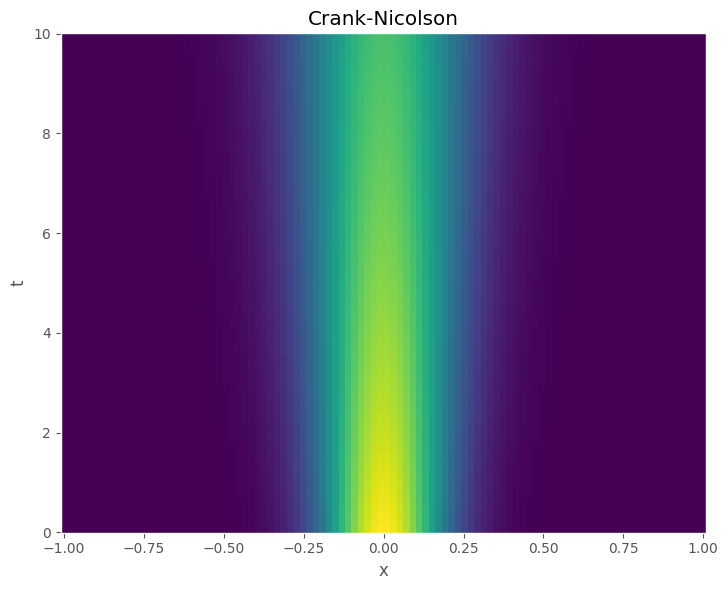

Max absolute gradient at left BC: 0.0013801548823930655
Max absolute gradient at right BC: 0.001380154882392999


In [67]:
# Defining parameters
kappa = 0.001  # diffusivity, original 0.001

# Timestepping parameters
t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
Nt = 1000  # number of timesteps

# Size of the physical domain
x_start = -1
x_end = 1
dx = x[1] - x[0]
Nx = 100

t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x

c_CN = CN_noforcedBCs(x, t, kappa) # Crank-Nicolson

# Plot the results
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 2)
plt.pcolormesh(x, t, c_CN.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank-Nicolson')

plt.tight_layout()
plt.show()

# verify BCs:
print("Max absolute gradient at left BC:", np.max(np.abs((c_CN[0, :] - c_CN[1, :]) / dx)))
print("Max absolute gradient at right BC:", np.max(np.abs((c_CN[-1, :] - c_CN[-2, :]) / dx)))



So the maximum observed gradient at the left and right side are very small, confirming that the BC is conserved. It's not exactly zero due to discretization errors. In the plots below, I zoomed in on the boundaries at t = 10, for a higher kappa value:

Crank-Nicolson method took 0.06 seconds


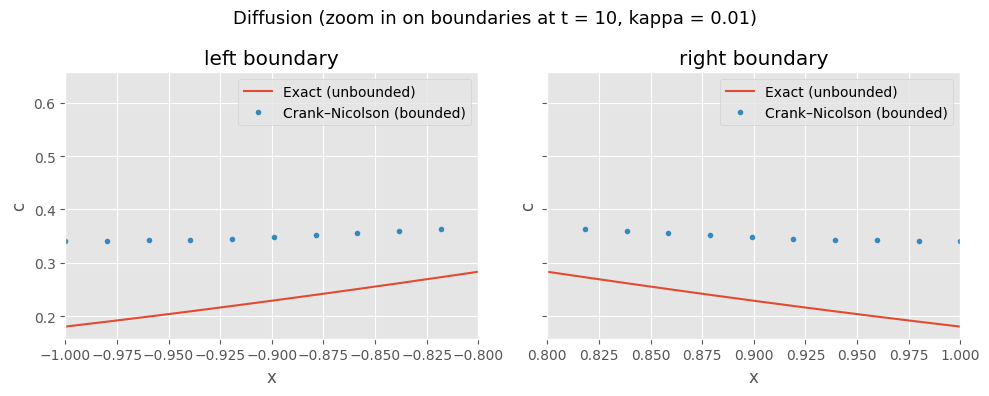

In [68]:
# Add code to plot exact and numerical solutions (zoom on edges)
kappa = 0.01
t_ic = 10

def exact_solution(x, t, kappa):
    return (4 * np.pi * kappa * t)**(-0.5) * np.exp(-x**2 / (4 * kappa * t))

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
c_CN = CN_noforcedBCs(x, t, kappa)
c_exact = exact_solution(x, t_end + t_ic, kappa)

for i, ax in enumerate(axes):
    ax.plot(x, c_exact, label="Exact (unbounded)")
    ax.plot(x, c_CN[:, -1], '.', label='Crank–Nicolson (bounded)')

    ax.set_xlabel('x')
    ax.set_ylabel('c')
    if i == 0:
        ax.set_title(f'left boundary')
        ax.set_xlim(-1.0, -0.8)   # left edge
    else:
        ax.set_title(f'right boundary')
        ax.set_xlim(0.8, 1.0)     # right edge

    ax.legend()

fig.suptitle('Diffusion (zoom in on boundaries at t = 10, kappa = 0.01)', fontsize=13)
plt.tight_layout()
plt.show()


Also here, the zero gradient is visibly satisfied at the boundaries.

**For Dirichlet (fixed value):**
1) Make the IC consistent with Dirichlet BC (certain fixed values at the boundaries)

2) Use the original construct_M function, and calculate A and B.

3) After this, change the first and last row of A and B to [1000...] and [...0001] so that boundary values remain fixed.

I believe this is the most straightforward solution. It might also be possbile by putting the first and last row of M full with zeros at step 2). However, this might cause numerical errors when A and B are inverted.

**For Neumann with constant non-zero gradient**

If we want a gradient 'a' at the boundaries, we want to impose

$c_{-1} = c_1 - 2 \, \Delta x \, a$.

After filling this in in the finite difference approx, we get the same term as for Neumann BC with zero gradient + an additional term. So we could use the same M matrix with -22000... on the first row of M and ...0002-2 on the last row, and add an additional vector b (with only this extra term in first and last row) into our PDE, so that we essentially get something of the form:

$\frac{dc}{dt} = \kappa * (Mc + b)$.

In the Crank-Nicolson scheme we can implement this by adding this term on right hand side and solve

$A\,\mathbf{c}^{n+1} = B\,\mathbf{c}^{n} + \Delta t\,\kappa\,b.$

If the fixed gradient on right and left side is different, then the first and last elements of b just take different values.

